In [1]:
import os
os.chdir('/content/drive/MyDrive/crowd')

In [2]:
import torch
import torch.nn as nn


class MCNN(nn.Module):
    '''
    Implementation of Multi-column CNN for crowd counting
    '''
    def __init__(self):
        super(MCNN,self).__init__()

        self.branch1=nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4)),
            nn.BatchNorm2d(16, eps=0.001, momentum=0, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3)),
            nn.BatchNorm2d(32, eps=0.001, momentum=0, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3)),
            nn.BatchNorm2d(16, eps=0.001, momentum=0, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(16, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3)),
            nn.BatchNorm2d(8, eps=0.001, momentum=0, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.branch2=nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3)),
            nn.BatchNorm2d(20, eps=0.001, momentum=0, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.BatchNorm2d(40, eps=0.001, momentum=0, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(40, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.BatchNorm2d(20, eps=0.001, momentum=0, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(20, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace=True)
        )

        self.branch3=nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.BatchNorm2d(24, eps=0.001, momentum=0, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(48, eps=0.001, momentum=0, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(48, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(24, eps=0.001, momentum=0, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(24, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(12, eps=0.001, momentum=0, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.fuse=nn.Sequential(
            nn.Sequential(nn.Conv2d(30, 1, kernel_size=(1, 1), stride=(1, 1))),
            nn.BatchNorm2d(1, eps=0.001, momentum=0, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )
    
    def forward(self,img_tensor):
        x1=self.branch1(img_tensor)
        x2=self.branch2(img_tensor)
        x3=self.branch3(img_tensor)
        x=torch.cat((x1,x2,x3),1)
        x=self.fuse(x)
        return x

In [3]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lrs
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.nn.utils import clip_grad_norm_
import os
import matplotlib.pyplot as plt
from matplotlib import cm as CM
import numpy as np
import torch
import cv2
from tqdm import tqdm
from matplotlib import cm as CM
import random

In [ ]:
random.seed(10)

In [4]:
class crowd_data(Dataset):
    def __init__(self,img_root,gt_dmap_root,gt_downsample=1,transform=None,transform1=None):
        self.img_root=img_root
        self.gt_dmap_root=gt_dmap_root
        self.gt_downsample=gt_downsample
        self.transform = transform
        self.transform1 = transform1

        self.images = [file for file in os.listdir(self.img_root)]
        self.n_samples=len(self.images)
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self,index):
        assert index <= len(self), 'index range error'
        img_name=self.images[index]
        img=plt.imread(os.path.join(self.img_root,img_name))
        if len(img.shape)==2: # expand grayscale image to three channel.
            img=img[:,:,np.newaxis]
            img=np.concatenate((img,img,img),2)
            
        gt_dmap=np.load(os.path.join(self.gt_dmap_root,img_name.replace('.jpg','.npy')))
        if self.gt_downsample > 1:
            ds_rows=int(img.shape[0]//self.gt_downsample)
            ds_cols=int(img.shape[1]//self.gt_downsample)
            img = cv2.resize(img,(ds_cols*self.gt_downsample,ds_rows*self.gt_downsample))
            img=img.transpose((2,0,1)) # convert to order (channel,rows,cols)
            gt_dmap=cv2.resize(gt_dmap,(ds_cols,ds_rows))
            gt_dmap=gt_dmap[np.newaxis,:,:]*self.gt_downsample*self.gt_downsample
            
        img_tensor=torch.tensor(img,dtype=torch.float)
        gt_dmap_tensor=torch.tensor(gt_dmap,dtype=torch.float)
        l = random.randint(0,9)
        if self.transform and self.transform1:
          if l > 5:
            img_tensor = self.transform(img_tensor)
            #gt_dmap_tensor = self.transform(gt_dmap_tensor)
          else:
            img_tensor = self.transform1(img_tensor)
            gt_dmap_tensor = self.transform1(gt_dmap_tensor)
        
        return img_tensor,gt_dmap_tensor

In [5]:
img_root = 'images_ab'
gt_dmap_root = 'density_map_ab'
gt_downsample = 4
transform = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
transform1 = transforms.Compose([transforms.CenterCrop(10)])

In [6]:
dataset_train = crowd_data(img_root, gt_dmap_root, gt_downsample=4)
dataloader = DataLoader(dataset_train, shuffle=True, batch_size=1)

In [7]:
len(dataset_train)

689

In [8]:
mcnn = MCNN()
mcnn = mcnn.cuda()
criterion = nn.MSELoss()
#optimizer = optim.SGD(mcnn.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

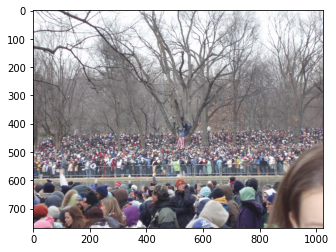

In [24]:
image_path = 'images/IMG_1.jpg'
image = plt.imread(image_path)
plt.imshow(image)

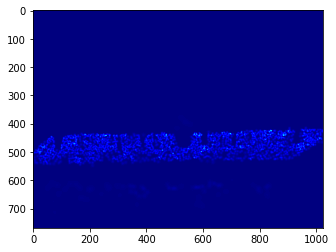

In [25]:
density_map_path = 'density_map/IMG_1.npy'
map = np.load(density_map_path)
plt.imshow(map, cmap=CM.jet)

In [9]:
checkpoint = torch.load('test.pt')
mcnn.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [14]:
optimizer = optim.SGD(mcnn.parameters(), lr=0.00001, momentum=0.9)

In [33]:
epochs= 100

In [ ]:
for epoch in range(epochs):
    running_loss = 0
    with tqdm(dataloader) as tqdm_epoch:
        for image, label in tqdm_epoch:
            tqdm_epoch.set_description(f"EPOCH {epoch+1}/{epochs}")
            
            image = image/255.0
            image = image.cuda()
            label = label * 100
            label = label.cuda()

            output = mcnn(image)
            loss = criterion(output, label)
            optimizer.zero_grad()
            loss.backward()
            
            #clip_grad_norm_(mcnn1.parameters(), max_norm=2.0)
            optimizer.step()
            
            running_loss += loss.item()
            tqdm_epoch.set_postfix(loss=loss.item())
        print('LOSS: ', running_loss/len(dataloader))

EPOCH 1/100: 100%|██████████| 689/689 [01:24<00:00,  8.11it/s, loss=134]


LOSS:  6.794631481714038


EPOCH 2/100: 100%|██████████| 689/689 [01:26<00:00,  7.94it/s, loss=1.96]


LOSS:  6.784304403936482


EPOCH 3/100: 100%|██████████| 689/689 [01:27<00:00,  7.88it/s, loss=0.43]


LOSS:  6.777010960763939


EPOCH 4/100: 100%|██████████| 689/689 [01:27<00:00,  7.84it/s, loss=0.0621]


LOSS:  6.771994801151671


EPOCH 5/100: 100%|██████████| 689/689 [01:28<00:00,  7.83it/s, loss=0.773]


LOSS:  6.7659632957233615


EPOCH 6/100: 100%|██████████| 689/689 [01:27<00:00,  7.85it/s, loss=0.0637]


LOSS:  6.759371647654515


EPOCH 7/100: 100%|██████████| 689/689 [01:27<00:00,  7.90it/s, loss=0.252]


LOSS:  6.754905450575497


EPOCH 8/100: 100%|██████████| 689/689 [01:27<00:00,  7.86it/s, loss=0.263]


LOSS:  6.744891369277382


EPOCH 9/100: 100%|██████████| 689/689 [01:27<00:00,  7.86it/s, loss=0.309]


LOSS:  6.742871736012756


EPOCH 10/100: 100%|██████████| 689/689 [01:27<00:00,  7.88it/s, loss=0.349]


LOSS:  6.735476961645943


EPOCH 11/100: 100%|██████████| 689/689 [01:27<00:00,  7.85it/s, loss=2.62]


LOSS:  6.730690866376237


EPOCH 12/100: 100%|██████████| 689/689 [01:27<00:00,  7.88it/s, loss=0.533]


LOSS:  6.721975646293973


EPOCH 13/100: 100%|██████████| 689/689 [01:27<00:00,  7.83it/s, loss=1.96]


LOSS:  6.71858035148823


EPOCH 14/100: 100%|██████████| 689/689 [01:27<00:00,  7.85it/s, loss=1.38]


LOSS:  6.719487217553663


EPOCH 15/100: 100%|██████████| 689/689 [01:27<00:00,  7.85it/s, loss=19.2]


LOSS:  6.708978756297115


EPOCH 16/100: 100%|██████████| 689/689 [01:27<00:00,  7.89it/s, loss=1.3]


LOSS:  6.702339218826681


EPOCH 17/100: 100%|██████████| 689/689 [01:27<00:00,  7.91it/s, loss=1.56]


LOSS:  6.704100673874984


EPOCH 18/100: 100%|██████████| 689/689 [01:27<00:00,  7.92it/s, loss=7.67]


LOSS:  6.692587116589913


EPOCH 19/100: 100%|██████████| 689/689 [01:27<00:00,  7.90it/s, loss=0.725]


LOSS:  6.687727220929586


EPOCH 20/100: 100%|██████████| 689/689 [01:27<00:00,  7.88it/s, loss=0.399]


LOSS:  6.687339564004078


EPOCH 21/100: 100%|██████████| 689/689 [01:27<00:00,  7.92it/s, loss=1.38]


LOSS:  6.678591263679185


EPOCH 22/100: 100%|██████████| 689/689 [01:26<00:00,  7.96it/s, loss=0.182]


LOSS:  6.673933584867545


EPOCH 23/100: 100%|██████████| 689/689 [01:26<00:00,  7.93it/s, loss=0.641]


LOSS:  6.666891278320564


EPOCH 24/100: 100%|██████████| 689/689 [01:26<00:00,  7.95it/s, loss=0.185]


LOSS:  6.668753157222457


EPOCH 25/100: 100%|██████████| 689/689 [01:27<00:00,  7.92it/s, loss=5.68]


LOSS:  6.660644461488667


EPOCH 26/100: 100%|██████████| 689/689 [01:28<00:00,  7.81it/s, loss=2.88]


LOSS:  6.656633486073729


EPOCH 27/100: 100%|██████████| 689/689 [01:29<00:00,  7.74it/s, loss=0.142]


LOSS:  6.648593391744617


EPOCH 28/100: 100%|██████████| 689/689 [01:29<00:00,  7.74it/s, loss=2.71]


LOSS:  6.6440817529122045


EPOCH 29/100: 100%|██████████| 689/689 [01:28<00:00,  7.83it/s, loss=0.5]


LOSS:  6.642449365788192


EPOCH 30/100: 100%|██████████| 689/689 [01:28<00:00,  7.79it/s, loss=132]


LOSS:  6.640321660721986


EPOCH 31/100: 100%|██████████| 689/689 [01:28<00:00,  7.78it/s, loss=2.17]


LOSS:  6.63813631897265


EPOCH 32/100: 100%|██████████| 689/689 [01:28<00:00,  7.78it/s, loss=0.602]


LOSS:  6.633416960221352


EPOCH 33/100: 100%|██████████| 689/689 [01:28<00:00,  7.76it/s, loss=0.126]


LOSS:  6.628696612051333


EPOCH 34/100: 100%|██████████| 689/689 [01:28<00:00,  7.79it/s, loss=0.795]


LOSS:  6.619371340619549


EPOCH 35/100: 100%|██████████| 689/689 [01:28<00:00,  7.81it/s, loss=0.262]


LOSS:  6.616002182272116


EPOCH 36/100: 100%|██████████| 689/689 [01:28<00:00,  7.80it/s, loss=18.5]


LOSS:  6.616205102984398


EPOCH 37/100: 100%|██████████| 689/689 [01:28<00:00,  7.80it/s, loss=0.789]


LOSS:  6.609846609183662


EPOCH 38/100: 100%|██████████| 689/689 [01:28<00:00,  7.82it/s, loss=0.353]


LOSS:  6.601957706956217


EPOCH 39/100: 100%|██████████| 689/689 [01:28<00:00,  7.80it/s, loss=14.7]


LOSS:  6.597074327747106


EPOCH 40/100: 100%|██████████| 689/689 [01:27<00:00,  7.84it/s, loss=1.05]


LOSS:  6.592054920338624


EPOCH 41/100: 100%|██████████| 689/689 [01:27<00:00,  7.83it/s, loss=14.6]


LOSS:  6.591750529598775


EPOCH 42/100: 100%|██████████| 689/689 [01:28<00:00,  7.82it/s, loss=0.673]


LOSS:  6.588943002645483


EPOCH 43/100: 100%|██████████| 689/689 [01:28<00:00,  7.81it/s, loss=11.4]


LOSS:  6.581955313847463


EPOCH 44/100: 100%|██████████| 689/689 [01:27<00:00,  7.87it/s, loss=4.94]


LOSS:  6.575314998202274


EPOCH 45/100: 100%|██████████| 689/689 [01:28<00:00,  7.82it/s, loss=0.141]


LOSS:  6.572699070725649


EPOCH 46/100: 100%|██████████| 689/689 [01:27<00:00,  7.86it/s, loss=0.663]


LOSS:  6.569275220623577


EPOCH 47/100: 100%|██████████| 689/689 [01:28<00:00,  7.79it/s, loss=3.36]


LOSS:  6.566794248359989


EPOCH 48/100: 100%|██████████| 689/689 [01:28<00:00,  7.82it/s, loss=0.136]


LOSS:  6.564616922978501


EPOCH 49/100: 100%|██████████| 689/689 [01:28<00:00,  7.79it/s, loss=0.327]


LOSS:  6.561053157336631


EPOCH 50/100: 100%|██████████| 689/689 [01:28<00:00,  7.80it/s, loss=3.32]


LOSS:  6.553571015772111


EPOCH 51/100: 100%|██████████| 689/689 [01:28<00:00,  7.77it/s, loss=0.124]


LOSS:  6.547458281802725


EPOCH 52/100: 100%|██████████| 689/689 [01:28<00:00,  7.75it/s, loss=1.86]


LOSS:  6.539761739762714


EPOCH 53/100: 100%|██████████| 689/689 [01:28<00:00,  7.78it/s, loss=0.316]


LOSS:  6.542079436418388


EPOCH 54/100: 100%|██████████| 689/689 [01:28<00:00,  7.78it/s, loss=19.2]


LOSS:  6.532781552031355


EPOCH 55/100: 100%|██████████| 689/689 [01:28<00:00,  7.79it/s, loss=1.36]


LOSS:  6.5334440850462165


EPOCH 56/100: 100%|██████████| 689/689 [01:28<00:00,  7.76it/s, loss=0.396]


LOSS:  6.531103051195924


EPOCH 57/100: 100%|██████████| 689/689 [01:28<00:00,  7.78it/s, loss=0.0723]


LOSS:  6.526981061681327


EPOCH 58/100: 100%|██████████| 689/689 [01:28<00:00,  7.78it/s, loss=38.6]


LOSS:  6.524293163101931


EPOCH 59/100: 100%|██████████| 689/689 [01:28<00:00,  7.78it/s, loss=1.44]


LOSS:  6.516028574279932


EPOCH 60/100: 100%|██████████| 689/689 [01:28<00:00,  7.76it/s, loss=18.3]


LOSS:  6.513320414546786


EPOCH 61/100: 100%|██████████| 689/689 [01:28<00:00,  7.78it/s, loss=10.5]


LOSS:  6.510179178032305


EPOCH 62/100: 100%|██████████| 689/689 [01:28<00:00,  7.76it/s, loss=2.24]


LOSS:  6.50843661627766


EPOCH 63/100: 100%|██████████| 689/689 [01:28<00:00,  7.79it/s, loss=1.93]


LOSS:  6.5007616131876


EPOCH 64/100: 100%|██████████| 689/689 [01:28<00:00,  7.76it/s, loss=0.135]


LOSS:  6.497082434605445


EPOCH 65/100: 100%|██████████| 689/689 [01:28<00:00,  7.76it/s, loss=0.0516]


LOSS:  6.4907953219004355


EPOCH 66/100: 100%|██████████| 689/689 [01:28<00:00,  7.76it/s, loss=7.34]


LOSS:  6.4915902403619885


EPOCH 67/100: 100%|██████████| 689/689 [01:28<00:00,  7.75it/s, loss=3.79]


LOSS:  6.487775296616234


EPOCH 68/100: 100%|██████████| 689/689 [01:28<00:00,  7.77it/s, loss=9.27]


LOSS:  6.4876829676724785


EPOCH 69/100: 100%|██████████| 689/689 [01:28<00:00,  7.78it/s, loss=2.32]


LOSS:  6.4809153178066055


EPOCH 70/100: 100%|██████████| 689/689 [01:28<00:00,  7.78it/s, loss=7.68]


LOSS:  6.476521036272709


EPOCH 71/100: 100%|██████████| 689/689 [01:28<00:00,  7.76it/s, loss=5.4]


LOSS:  6.473800700728299


EPOCH 72/100: 100%|██████████| 689/689 [01:28<00:00,  7.75it/s, loss=4.6]


LOSS:  6.47193475905941


EPOCH 73/100: 100%|██████████| 689/689 [01:28<00:00,  7.74it/s, loss=0.571]


LOSS:  6.4699823898040245


EPOCH 74/100: 100%|██████████| 689/689 [01:28<00:00,  7.74it/s, loss=0.0327]


LOSS:  6.466022542270958


EPOCH 75/100: 100%|██████████| 689/689 [01:29<00:00,  7.72it/s, loss=0.648]


LOSS:  6.460890024511146


EPOCH 76/100: 100%|██████████| 689/689 [01:28<00:00,  7.78it/s, loss=0.14]


LOSS:  6.457891664001415


EPOCH 77/100: 100%|██████████| 689/689 [01:28<00:00,  7.79it/s, loss=0.339]


LOSS:  6.456468730835117


EPOCH 78/100:   6%|▌         | 39/689 [00:04<01:26,  7.55it/s, loss=0.141]

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': mcnn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'test.pt')

In [ ]:
loss

tensor(0.1452, device='cuda:0', grad_fn=<MseLossBackward0>)

In [11]:
dataset_test = crowd_data(img_root, gt_dmap_root, gt_downsample=4)
dataloader_test = DataLoader(dataset_train, shuffle=True, batch_size=1)

In [12]:
for data in dataloader_test:
    img, lbl = data
    img = img.cuda()
    
    img = img/255.0
    #lbl = lbl * 100
    
    output = mcnn(img)
    print('PREDICTED: ',(output.sum()/100).item(), 'ACTUAL: ', (lbl.sum().item()))
    print()

PREDICTED:  183.9481658935547 ACTUAL:  82.86589813232422

PREDICTED:  40.25800704956055 ACTUAL:  54.77568054199219

PREDICTED:  401.999755859375 ACTUAL:  260.7939147949219

PREDICTED:  128.8024444580078 ACTUAL:  103.9167251586914

PREDICTED:  1334.068603515625 ACTUAL:  1658.281494140625

PREDICTED:  65.76326751708984 ACTUAL:  94.28565216064453

PREDICTED:  145.05531311035156 ACTUAL:  150.12619018554688

PREDICTED:  861.7394409179688 ACTUAL:  900.5523071289062

PREDICTED:  79.79957580566406 ACTUAL:  29.900352478027344

PREDICTED:  60.91371536254883 ACTUAL:  68.80398559570312

PREDICTED:  144.65359497070312 ACTUAL:  83.903564453125

PREDICTED:  248.07081604003906 ACTUAL:  246.2852020263672

PREDICTED:  39.396114349365234 ACTUAL:  69.59555053710938

PREDICTED:  203.86065673828125 ACTUAL:  97.70761108398438

PREDICTED:  173.55191040039062 ACTUAL:  260.1848449707031

PREDICTED:  198.1288604736328 ACTUAL:  109.28704071044922

PREDICTED:  193.52296447753906 ACTUAL:  190.87803649902344

PREDIC

In [32]:
lbl.sum().item(), (output/100).sum().item()

(122.42301940917969, 118.5797119140625)

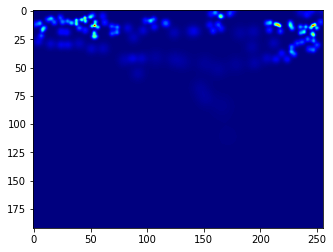

In [31]:
a = np.reshape(lbl[0].numpy(),(lbl[0].shape[1],lbl[0].shape[2]))
plt.imshow(a,cmap=CM.jet)

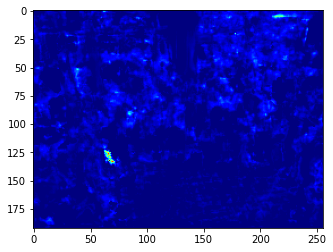

In [30]:
b = (output/100).detach().cpu().numpy()
b = np.reshape(b,(b.shape[2],b.shape[3]))
plt.imshow(b,cmap=CM.jet)